✅ Number of images per class:
  clear face: 97
  darkspots: 99
  puffy eyes: 101
  wrinkles: 100


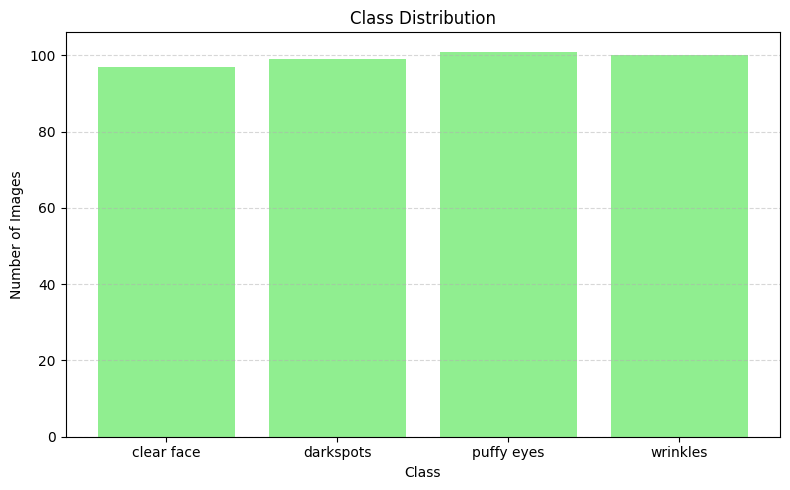

In [6]:
import os
import matplotlib.pyplot as plt
DATASET_DIR = r"C:\Users\rasoo\Dermalskin\data\labeled\dataset\train"
ALLOWED_EXTENSIONS = ['.jpeg', '.jpg', '.png']
class_folders = [f for f in os.listdir(DATASET_DIR) 
                 if os.path.isdir(os.path.join(DATASET_DIR, f))]
class_counts = {}
for cls in class_folders:
    cls_path = os.path.join(DATASET_DIR, cls)
    cls_images = [f for f in os.listdir(cls_path)
                  if os.path.splitext(f)[1].lower() in ALLOWED_EXTENSIONS]
    class_counts[cls] = len(cls_images)
print(" Number of images per class:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count}")
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Found 631 images belonging to 4 classes.
Found 156 images belonging to 4 classes.
Class indices: {'clear face': 0, 'darkspots': 1, 'puffy eyes': 2, 'wrinkles': 3}


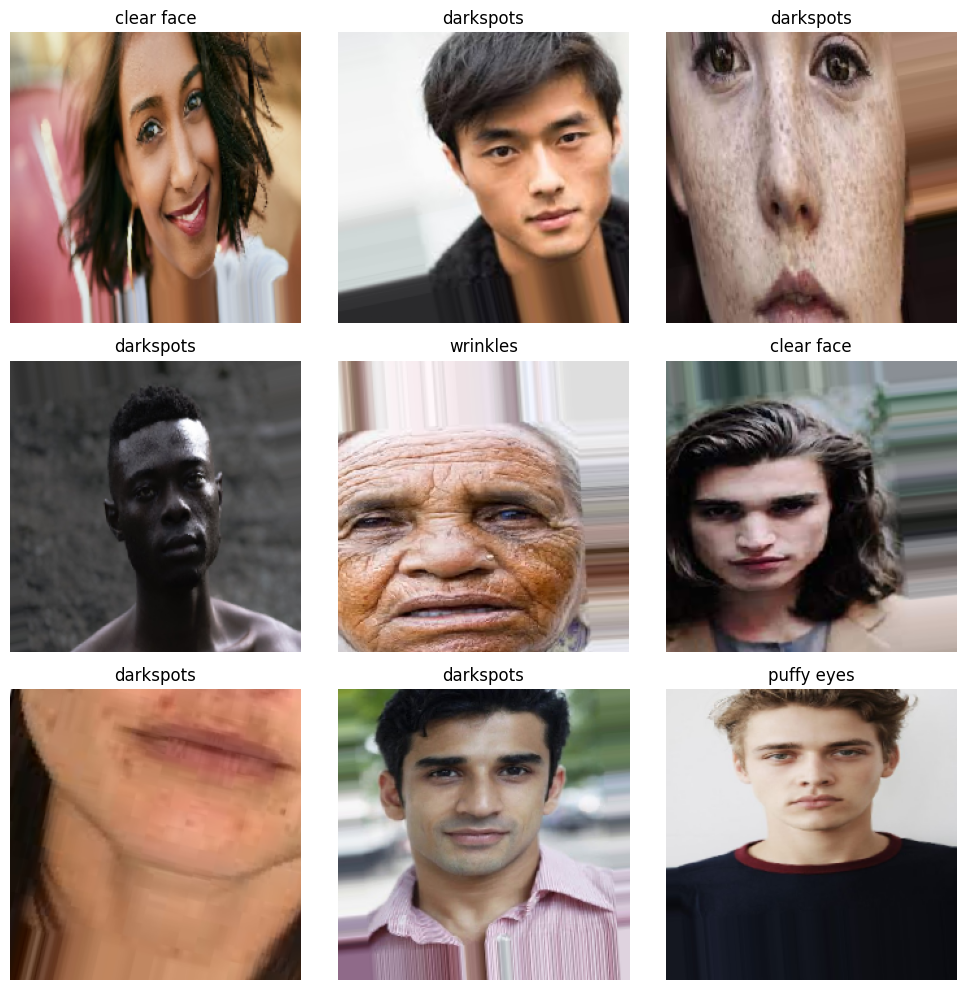

In [7]:
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # pyright: ignore[reportMissingImports]
import matplotlib.pyplot as plt
import os
DATASET_DIR = r"C:\Users\rasoo\Dermalskin\data\labeled\dataset\train"
if not os.path.isdir(DATASET_DIR):
    raise SystemExit(f"ERROR: dataset folder not found: {DATASET_DIR}")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)
val_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)
print("Class indices:", train_generator.class_indices)
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(min(9, len(x_batch))):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(list(train_generator.class_indices.keys())[y_batch[i].argmax()])
    plt.axis("off")
plt.tight_layout()
plt.savefig(r"C:\Users\rasoo\Dermalskin\script\aug_preview.png")
plt.show()


✅ TensorFlow version: 2.13.0
✅ GPU Available: 0
Found 574 images belonging to 4 classes.
Found 465 images belonging to 4 classes.
Epoch 1/15
36/36 [==============================] - ETA: 0s - loss: 1.1736 - accuracy: 0.5296  
Epoch 1: val_accuracy improved from -inf to 0.64731, saving model to mobilenet_best.h5


C:\Users\rasoo\.conda\envs\dermalskin\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 43s 982ms/step - loss: 1.1736 - accuracy: 0.5296 - val_loss: 0.8191 - val_accuracy: 0.6473 - lr: 1.0000e-04
Epoch 2/15
36/36 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.7787 
Epoch 2: val_accuracy improved from 0.64731 to 0.71828, saving model to mobilenet_best.h5
36/36 [==============================] - 29s 809ms/step - loss: 0.6015 - accuracy: 0.7787 - val_loss: 0.6636 - val_accuracy: 0.7183 - lr: 1.0000e-04
Epoch 3/15
36/36 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.8223 
Epoch 3: val_accuracy did not improve from 0.71828
36/36 [==============================] - 27s 749ms/step - loss: 0.4456 - accuracy: 0.8223 - val_loss: 0.6896 - val_accuracy: 0.7032 - lr: 1.0000e-04
Epoch 4/15
36/36 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8746 
Epoch 4: val_accuracy improved from 0.71828 to 0.79355, saving model to mobilenet_best.h5
36/36 [==============================

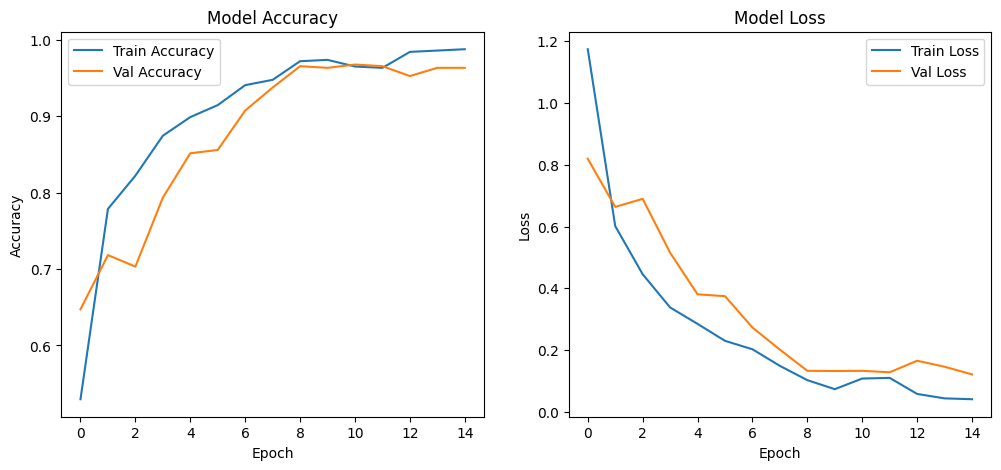

🏆 Final Train Accuracy: 98.78%
🏆 Final Validation Accuracy: 96.34%
✅ Model saved as 'DermalSkin_MobileNetV2_Finetuned.h5'


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import os
print("✅ TensorFlow version:", tf.__version__)
print("✅ GPU Available:", len(tf.config.list_physical_devices('GPU')))
train_dir = r"C:\Users\rasoo\Dermalskin\data\train"
val_dir   = r"C:\Users\rasoo\Dermalskin\data\val"
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=16, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(224,224), batch_size=16, class_mode='categorical')
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("mobilenet_best.h5", monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

history = model.fit(train_gen, validation_data=val_gen, epochs=15,
                    callbacks=[checkpoint, early_stop, lr_reduce], verbose=1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Model Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Model Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.show()
train_acc = history.history['accuracy'][-1]*100
val_acc = history.history['val_accuracy'][-1]*100
print(f"🏆 Final Train Accuracy: {train_acc:.2f}%")
print(f"🏆 Final Validation Accuracy: {val_acc:.2f}%")
model.save("DermalSkin_MobileNetV2_Finetuned.h5")
print("✅ Model saved as 'DermalSkin_MobileNetV2_Finetuned.h5'")


 Model loaded successfully!
1/1 [==============================] - 1s 1s/step
 Image analyzed: 15.jpeg
 Face Type: clear face
 Confidence: 99.99%
 Estimated Age: 23
 Output saved at: C:\Users\rasoo\Dermalskin\output_clear_472e816e183e49aa90e0dcb8e63e8cb6.jpg


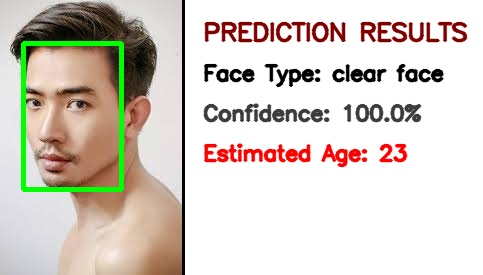

------------------------------------------------------------
1/1 [==============================] - 0s 62ms/step
 Image analyzed: 27.jpg
 Face Type: dark spots
 Confidence: 98.60%
 Estimated Age: 35
 Output saved at: C:\Users\rasoo\Dermalskin\output_clear_46b0f2fb26e84ca2bd047332e8edf92f.jpg


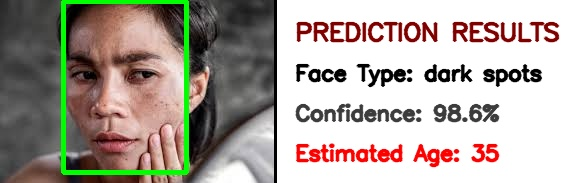

------------------------------------------------------------
1/1 [==============================] - 0s 111ms/step
 Image analyzed: 39.jpg
 Face Type: clear face
 Confidence: 99.98%
 Estimated Age: 21
 Output saved at: C:\Users\rasoo\Dermalskin\output_clear_e6b01f6f83c84dfca296457407e6c8fe.jpg


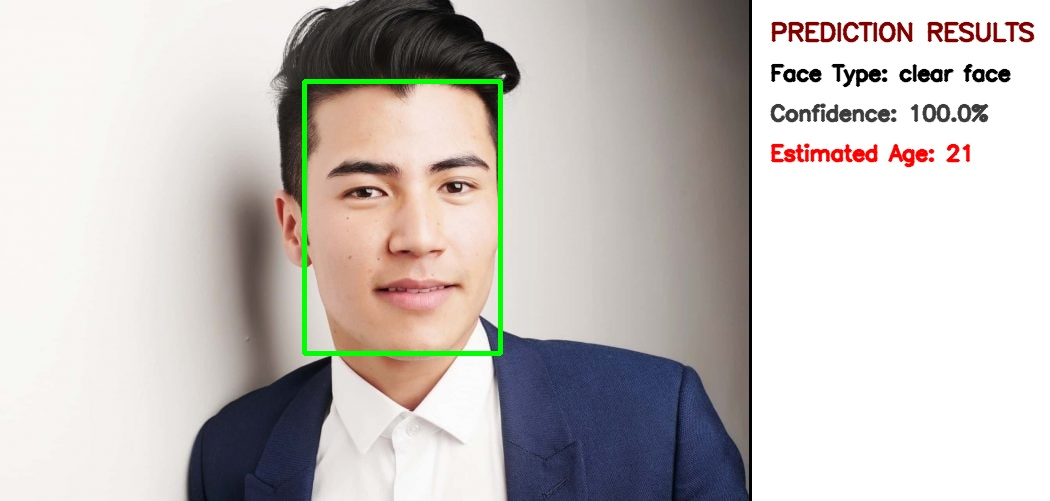

------------------------------------------------------------
1/1 [==============================] - 0s 77ms/step
 Image analyzed: 68.jpg
 Face Type: clear face
 Confidence: 99.96%
 Estimated Age: 30
 Output saved at: C:\Users\rasoo\Dermalskin\output_clear_45616f7ac1874fc3836ac4dda6334284.jpg


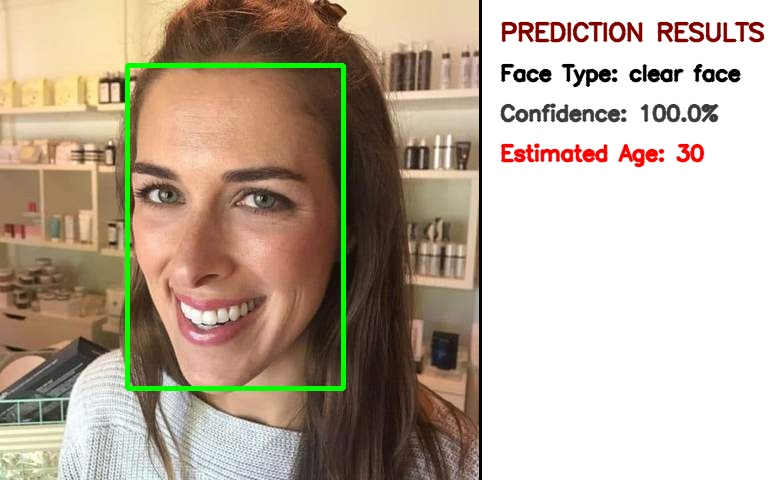

------------------------------------------------------------


In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from random import randint
import uuid
from IPython.display import display, Image
model_path = r"C:\Users\rasoo\Dermalskin\DermalSkin_MobileNetV2_Finetuned.h5"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}")
model = load_model(model_path)
print(" Model loaded successfully!")
face_classes = ["clear face", "dark spots", "puffy eyes", "wrinkles"]
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img
def predict_face(image_path):
    img = preprocess_image(image_path)
    if img is None:
        return "Unknown", "Unknown", None
    preds = model.predict(img)
    class_index = np.argmax(preds, axis=1)[0]
    confidence = float(np.max(preds)) * 100
    face_type = face_classes[class_index]
    if face_type == "clear face":
        age = randint(18, 30)
    elif face_type == "dark spots":
        age = randint(30, 40)
    elif face_type == "puffy eyes":
        age = randint(40, 55)
    else:
        age = randint(55, 70)

    return face_type, age, confidence
def detect_face_and_display(image_path, face_type, age, confidence):
    img = cv2.imread(image_path)
    if img is None:
        return None
    protoPath = r"C:\Users\rasoo\Dermalskin\models\deploy.prototxt"
    modelPath = r"C:\Users\rasoo\Dermalskin\models\res10_300x300_ssd_iter_140000.caffemodel"
    if not os.path.exists(protoPath) or not os.path.exists(modelPath):
        raise FileNotFoundError(" Missing DNN face detector files! Please check paths.")
    net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0,
                                 (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    for i in range(0, detections.shape[2]):
        confidence_face = detections[0, 0, i, 2]
        if confidence_face > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    panel_width = 300
    new_width = w + panel_width
    output_img = np.ones((h, new_width, 3), dtype=np.uint8) * 255  # white panel
    output_img[:, :w] = img
    cv2.line(output_img, (w, 0), (w, h), (0, 0, 0), 2)
    text_x = w + 20
    y_pos = 80
    cv2.putText(output_img, "PREDICTION RESULTS", (text_x, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 128), 2, cv2.LINE_AA)
    cv2.putText(output_img, f"Face Type: {face_type}", (text_x, y_pos),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(output_img, f"Confidence: {confidence:.1f}%", (text_x, y_pos + 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (60, 60, 60), 2, cv2.LINE_AA)
    cv2.putText(output_img, f"Estimated Age: {age}", (text_x, y_pos + 80),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)
    output_path = os.path.join(os.getcwd(), f"output_clear_{uuid.uuid4().hex}.jpg")
    cv2.imwrite(output_path, output_img)
    return output_path
def analyze_face(image_path):
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return
    face_type, age, confidence = predict_face(image_path)
    output_image_path = detect_face_and_display(image_path, face_type, age, confidence)
    print(f" Image analyzed: {os.path.basename(image_path)}")
    print(f" Face Type: {face_type}")
    print(f" Confidence: {confidence:.2f}%")
    print(f" Estimated Age: {age}")
    if output_image_path:
        print(f" Output saved at: {output_image_path}")
        display(Image(filename=output_image_path))
    else:
        print("No face detected in the image.")
    print("-" * 60)
images_folder = r"C:\Users\rasoo\Dermalskin\TestImages"
supported_exts = ('.jpg', '.jpeg', '.png')
if not os.path.exists(images_folder):
    raise FileNotFoundError(f"Folder not found: {images_folder}")
all_images = [
    os.path.join(images_folder, f)
    for f in os.listdir(images_folder)
    if f.lower().endswith(supported_exts)
]
if not all_images:
    print(f"No images found in folder: {images_folder}")
else:
    for img_path in all_images:
        analyze_face(img_path)
